In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib
from scipy import stats
import copy
from function import confid

import cartopy.crs as ccrs                   # import projections
import cartopy

from scipy.io import loadmat

In [12]:
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.close('all')

__figdir__ = './'
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}

savefig = True # flag to write plots to files
plotswot = False # flag to include plot of SWOT cal/val track

In [4]:
xmin, xmax = (125,290)
ymin, ymax = (-28,61)

In [8]:
# data for fft of running avergaed filtered ssh
path = '/vortexfs1/home/wwu/Rossby_Wave_Project/data/fft_resample_hann_detrend_ssh_14yrs_all_freqs.nc'
#path = 'fft_filtered_hann_detrend_ssh_14yrs_all_freqs.nc'
nc = Dataset(path,'r')
lon,lat = np.meshgrid(nc.variables['lon'][:],nc.variables['lat'][:])
lon =360*(lon<0)+lon
fft_h = nc.variables['fftreal'][150:160,:,:] \
       + 1j* nc.variables['fftimg'][150:160,:,:]
N = 1022. # number of data points (use later to normalize fft output)
# the spacing of frequency 
df = nc.variables['cycle_per_day'][1]- nc.variables['cycle_per_day'][0]


# data for fft of 0.1 degree resolution SU,SV (depth-averaged U,V in cm/s)
path2= '/vortexfs1/home/wwu/Rossby_Wave_Project/data/fft_su_hann_33_day.nc'
path3= '/vortexfs1/home/wwu/Rossby_Wave_Project/data/fft_sv_hann_33_day.nc'
#path2 = 'data/fft_su_hann_33_day.nc'
#path3 = 'data/fft_sv_hann_33_day.nc'
nc2 = Dataset(path2,'r')
fft_u = nc2.variables['fft_su_real'][:] \
       + 1j* nc2.variables['fft_su_img'][:]
nc3 = Dataset(path3,'r')
fft_v = nc3.variables['fft_sv_real'][:] \
       + 1j* nc3.variables['fft_sv_img'][:]
R0 = 1.027 # sea water density in g/cm^3
# SU, SV are in unit of cm/s
S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)
#S_ke = 0.5 * R0 *(S_u + S_v) 

loc = np.empty(2,) # index of reference point
loc[0] = 354
loc[1] = 1100

x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]

In [9]:
fft_ref = fft_h[:,int(loc[0]),int(loc[1])]
S_ref = np.mean(2.*(np.absolute(fft_ref)**2.)/(N**2. * df),axis = 0)


cp = fft_u*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_u = np.absolute(C_lf)**2./(S_u*S_ref)

cp = fft_v*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_v = np.absolute(C_lf)**2./(S_v*S_ref)

frac = (coh_u*S_u + coh_v*S_v)/ (S_u + S_v)

#Coherence error bar (dof for hann window is considered)
errbar = np.sqrt(1.-(0.05)**(1./( (10/1.9445) -1))) 

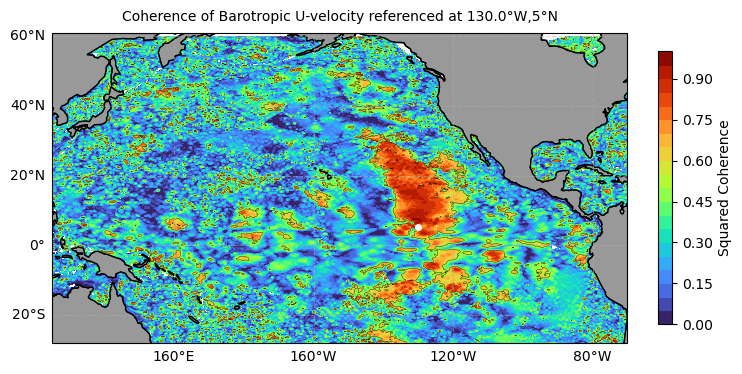

In [15]:
fig = plt.figure()
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Coherence of Barotropic U-velocity referenced at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.contourf(lon,lat,coh_u, levels, transform=ccrs.PlateCarree())
plt.contour(lon,lat,coh_u,[errbar**2.],colors= 'black',linewidths = 0.3, transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Squared Coherence',fontsize = 10)

x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]
plt.plot(x0, y0, marker='o',color='white',transform=ccrs.PlateCarree(),markersize = 4);

plt.savefig(__figdir__+'SU_coher_raw.png',**savefig_args)

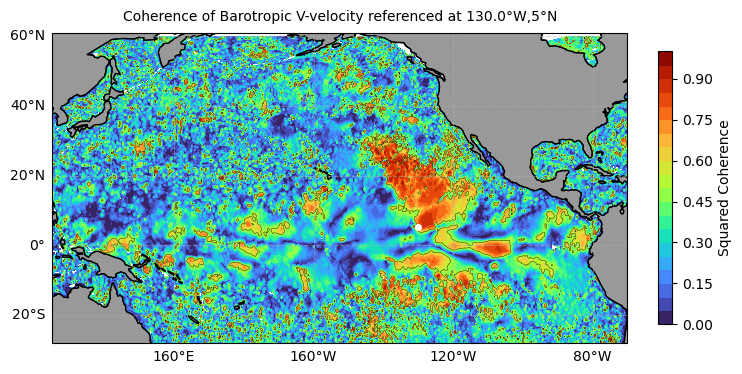

In [14]:
fig = plt.figure()
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Coherence of Barotropic V-velocity referenced at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.contourf(lon,lat,coh_v, levels, transform=ccrs.PlateCarree())
plt.contour(lon,lat,coh_v,[errbar**2.],colors= 'black',linewidths = 0.3, transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Squared Coherence',fontsize = 10)

x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]
plt.plot(x0, y0, marker='o',color='white',transform=ccrs.PlateCarree(),markersize = 4);

plt.savefig(__figdir__+'SV_coher_raw.png',**savefig_args)

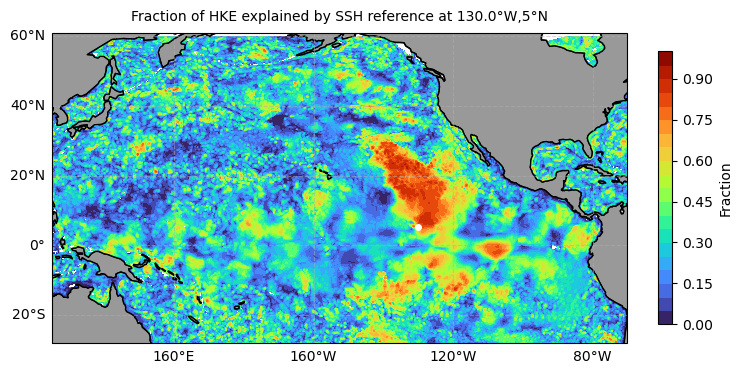

In [16]:
fig = plt.figure()
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Fraction of HKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.contourf(lon,lat,frac, levels, transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Fraction',fontsize = 10)

x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]
plt.plot(x0, y0, marker='o',color='white',transform=ccrs.PlateCarree(),markersize = 4);

plt.savefig(__figdir__+'HKE_fraction_raw.png',**savefig_args)